In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple

import celeri

plt.rcParams["text.usetex"] = False # Plotting the global model is much much faster with tex fonts turned off

# Read in data files, create storage dictionaries, and do basic processing

In [3]:
command_file_name = "../data/western_north_america/basic_command.json"
command_file_name = "../data/japan/japan_new481_shannon_command.json"

command, segment, block, meshes, station, mogi, sar = celeri.read_data(command_file_name)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar) # Not sure this works correctly

Warning: The file contains tag data that couldn't be processed.

Warning: The file contains tag data that couldn't be processed.

Warning: The file contains tag data that couldn't be processed.

In [4]:
def plot_block_station_label(block_label, lon_range, lat_range):
    plt.figure(figsize=(20, 10))
    # s = slip_rates2[0::3]
    for i in range(len(segment)):
        plt.plot([segment.lon1[i], segment.lon2[i]], [segment.lat1[i], segment.lat2[i]], "-b", linewidth=0.25, clip_on=True)
        if (segment.east_labels[i] == block_label) or (segment.west_labels[i] == block_label):
            plt.plot([segment.lon1[i], segment.lon2[i]], [segment.lat1[i], segment.lat2[i]], "-r", linewidth=3.00, clip_on=True)
            plt.text(segment.mid_lon_plate_carree[i], segment.mid_lat_plate_carree[i], str(block_label), color="r", clip_on=True)

    plt.plot(station.lon, station.lat, ".b")
    for i in range(len(station)):
        if station.block_label[i] == block_label:
            station_handle = plt.plot(station.lon[i], station.lat[i], ".r")
            plt.text(station.lon[i], station.lat[i], str(station.block_label[i]), clip_on=True, color="r")

    plt.plot(block.interior_lon, block.interior_lat, "+k")
    for i in range(len(block)):
        if block.block_label[i] == block_label:
            block_handle = plt.plot(block.interior_lon[i], block.interior_lat[i], "+g")
            plt.text(block.interior_lon[i], block.interior_lat[i], str(block.block_label[i]), clip_on=True, color="g")

    plt.title("block " + str(block_label))
    plt.xlim((lon_range[0], lon_range[1]))
    plt.ylim((lat_range[0], lat_range[1]))
    plt.gca().set_aspect("equal", adjustable="box")
    plt.show()

# Critical examples from Asia

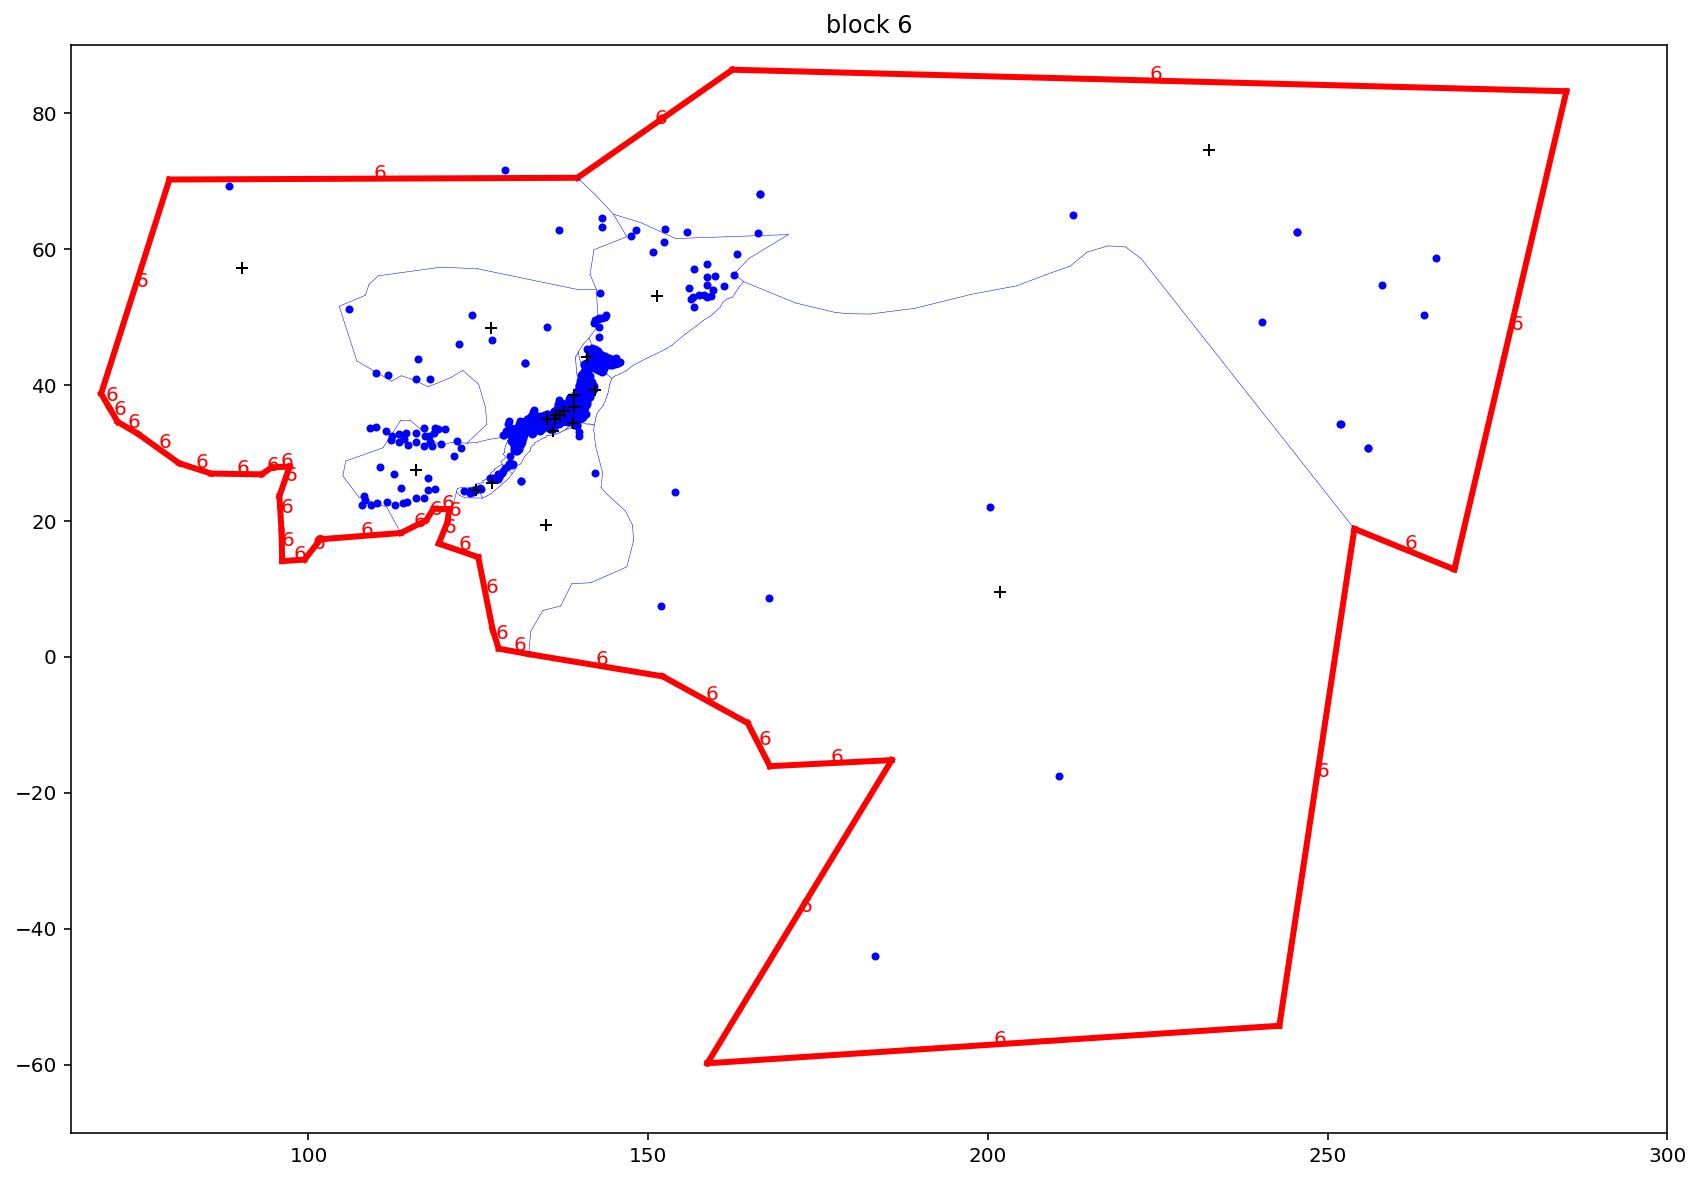

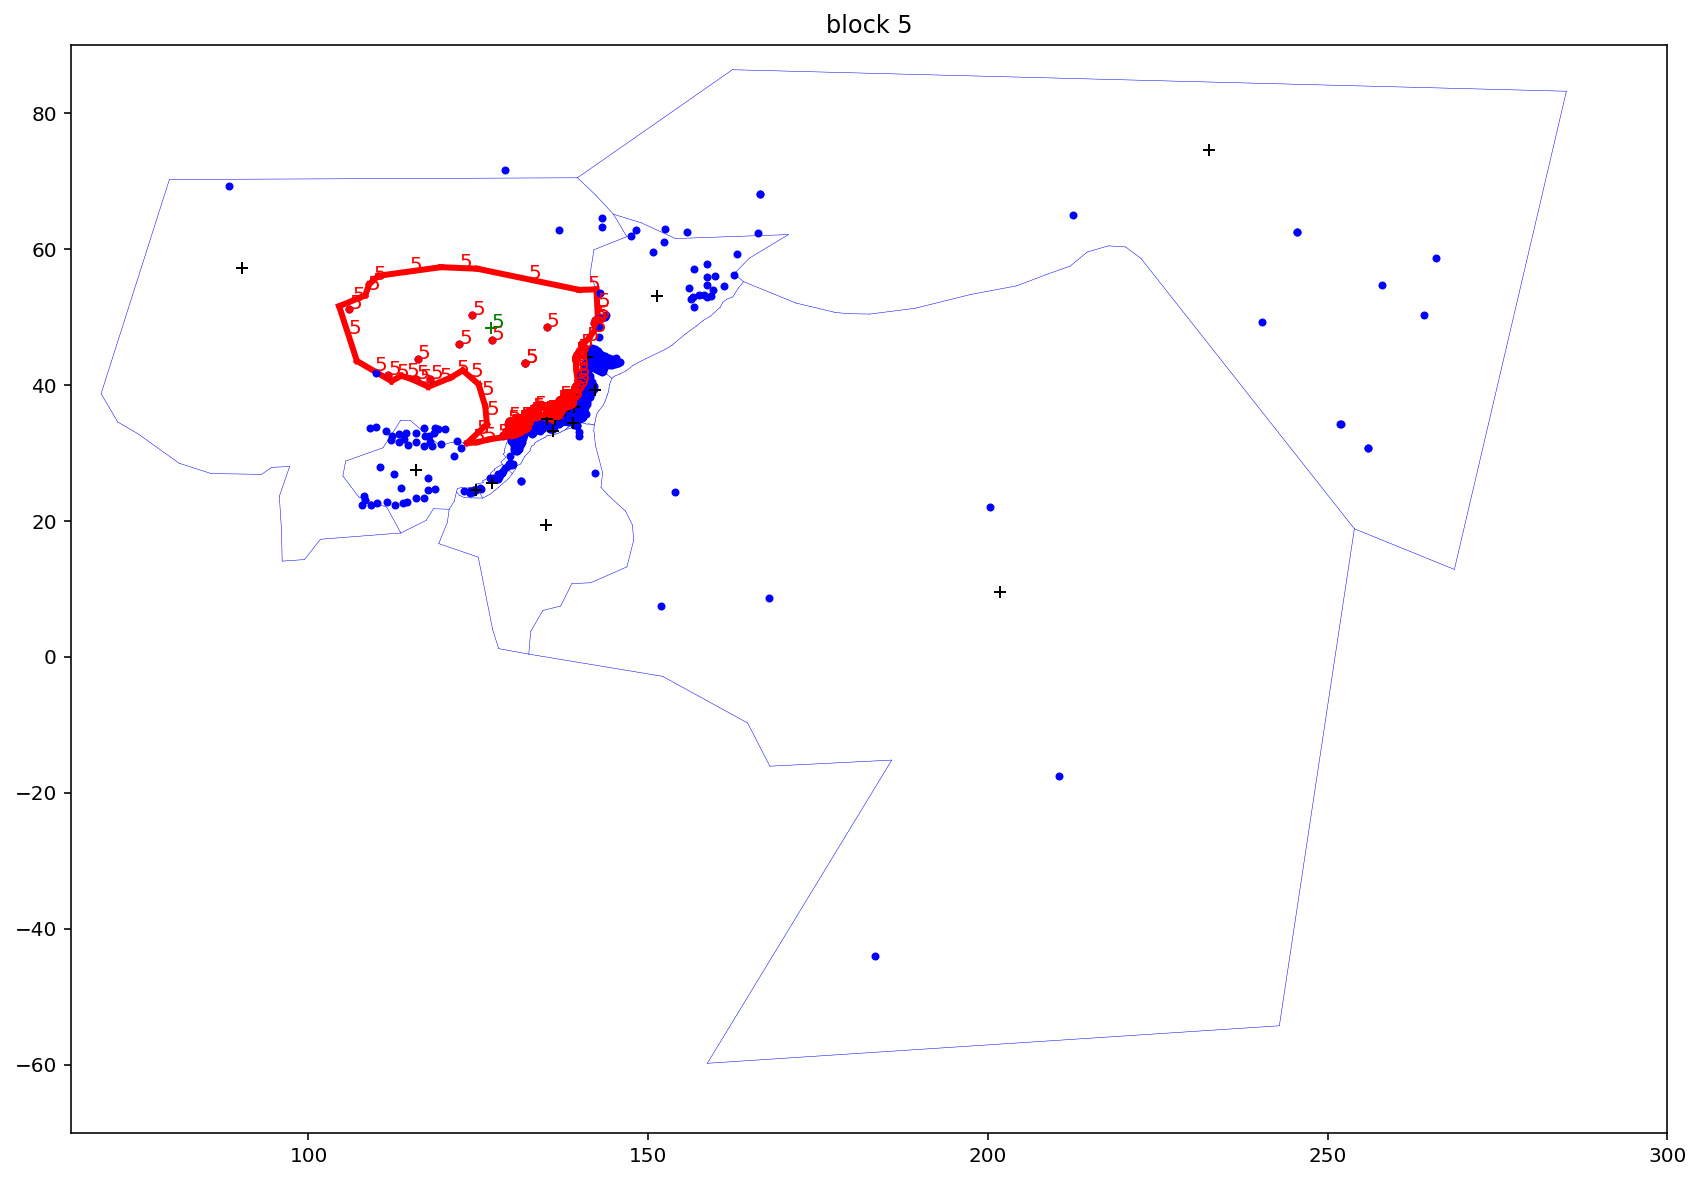

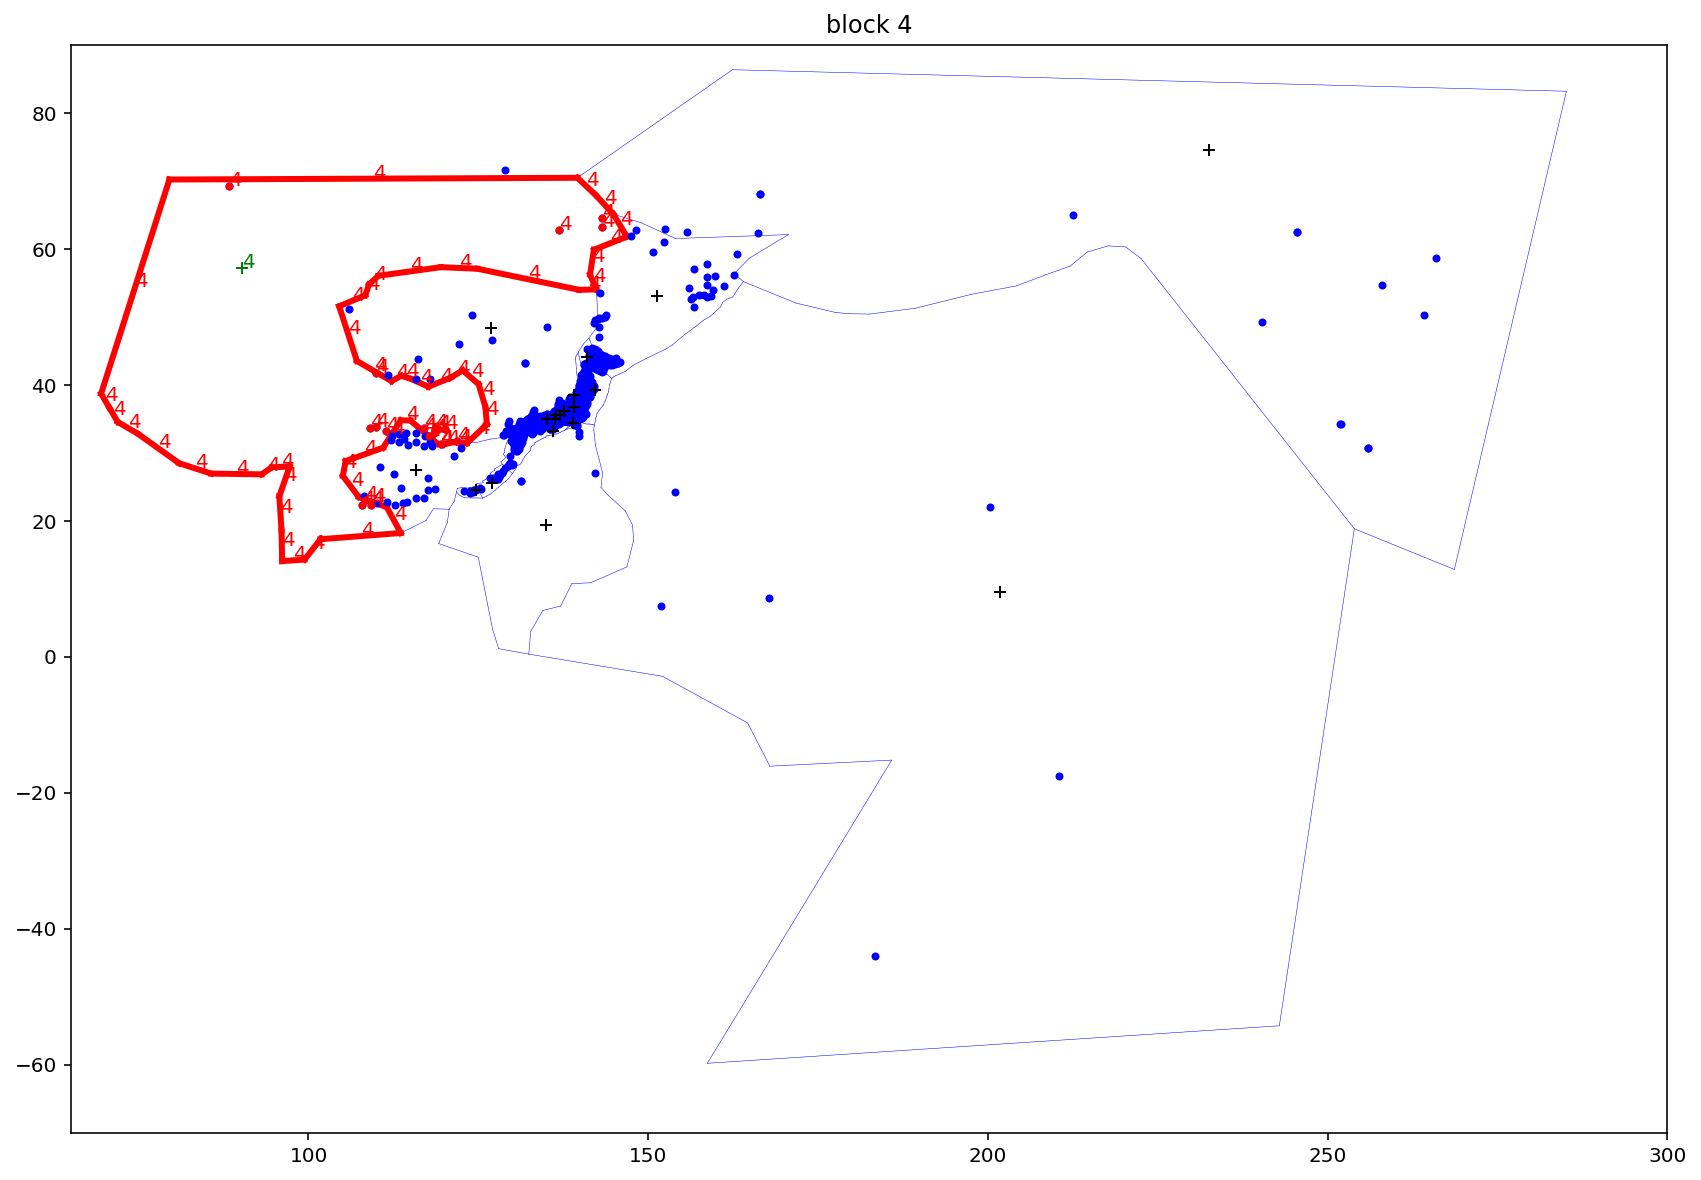

In [5]:
plot_block_station_label(block_label=6, lon_range=(65.0, 300.0), lat_range=(-70.0, 90.0))
plot_block_station_label(block_label=5, lon_range=(65.0, 300.0), lat_range=(-70.0, 90.0))
plot_block_station_label(block_label=4, lon_range=(65.0, 300.0), lat_range=(-70.0, 90.0))

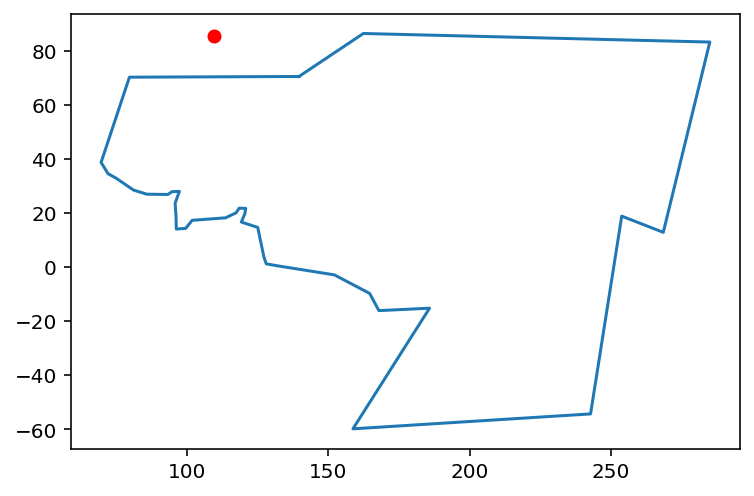

In [6]:
plt.plot(closure.polygons[6].vertices[:, 0], closure.polygons[6].vertices[:, 1])
plt.plot(closure.polygons[6].interior[:1], closure.polygons[6].interior[1:2], 'ro')
plt.show()

In [7]:
closure.polygons[6].contains_point(station.lon[61:62], station.lat[61:62])

/Users/tbent/Dropbox/active/eq/celeri/celeri/celeri_closure.py:331: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  C = np.hstack((x[:, None], y[:, None], z[:, None]))


array([False])